  ### Alternative Risk Premia Projet 2022 - Lucas Boulanger, Lucas Ducrocq, Jnaina Harmel

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import t
from IPython.display import display_html
from itertools import chain,cycle

### Fonction permettant d'afficher plusieurs DataFrames à la fois

In [2]:
def display_side_by_side(*args,titles=cycle([''])):
    
    html_str=''
    
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
   
    display_html(html_str,raw=True)

### Définition des paramètres et préparation des données 

In [3]:
formp = 3 # Période de formation des portefeuilles basés sur les quintiles de Beta de 3 ans
estp = 3 # Période de réestimation des Betas de 3 ans suivant la période de formation
testp = 1 # Période de test du size effect de 1 an
Gammas_Deltas= pd.DataFrame() # DataFrame ou seront stockés les coefficients associés aux Betas et Log Capitalisations
MeanMonthlyXRET = pd.DataFrame() # DataFrame ou seront stockés les rendements mensuels moyens pour les 16 tests

In [4]:
d1 = pd.read_csv("Size premium data.csv")
print(d1.iloc[492208])

PERMNO        92583
date       20020628
PRC            -2.7
RET       -0.107438
SHROUT         2928
vwretd    -0.070259
Name: 492208, dtype: object


In [5]:
d1["PRC"] = d1["PRC"].apply(lambda x : x if x > 0 else - x) # Remplacement des prix négatifs par leur opposé 
print(d1.iloc[492208]) 

PERMNO        92583
date       20020628
PRC             2.7
RET       -0.107438
SHROUT         2928
vwretd    -0.070259
Name: 492208, dtype: object


In [6]:
NAdict = {-99:np.nan, -88:np.nan, -77:np.nan, -66:np.nan, "B":np.nan, "C":np.nan}
d1 = d1.replace({"RET" : NAdict}) # Elimination des valeurs manquantes parmi les rendements
d1["RET"] = d1["RET"].astype(float)
d1["RET"].describe()

count    489513.000000
mean          0.012760
std           0.141226
min          -0.944404
25%          -0.044418
50%           0.008251
75%           0.060285
max          13.495050
Name: RET, dtype: float64

In [7]:
minYear = int((d1["date"].min()) / 10000) # Récupération de l'année minimum dans le DataFrame
d1["Period"] = (d1["date"] / 10000).astype(int) - minYear + 1
# Création de la colonne Périod telle que l'année minimum correspond à la période 1, l'année suivante correspond à la période 2 etc...
d1.head() 

,PERMNO,date,PRC,RET,SHROUT,vwretd,Period
0,10026,20000131,19.1250,-0.067073,9017.0,-0.039622,1
1,10026,20000229,18.4375,-0.035948,9017.0,0.031760,1
2,10026,20000331,19.8750,0.077966,8980.0,0.053499,1
3,10026,20000428,15.9375,-0.198113,8810.0,-0.059519,1
4,10026,20000531,14.8750,-0.066667,8810.0,-0.038860,1


In [8]:
d1["YearMonth"] = (d1["date"] / 100).astype(int) # Création de la colonne YearMonth permettant de merge les données avec celles de Fama & French
d1["Month"] = pd.to_datetime(d1["date"], format = "%Y%m%d").dt.month # Création de la colonne Month affichant le mois de la période en cours
d1.head()

,PERMNO,date,PRC,RET,SHROUT,vwretd,Period,YearMonth,Month
0,10026,20000131,19.1250,-0.067073,9017.0,-0.039622,1,200001,1
1,10026,20000229,18.4375,-0.035948,9017.0,0.031760,1,200002,2
2,10026,20000331,19.8750,0.077966,8980.0,0.053499,1,200003,3
3,10026,20000428,15.9375,-0.198113,8810.0,-0.059519,1,200004,4
4,10026,20000531,14.8750,-0.066667,8810.0,-0.038860,1,200005,5


In [9]:
d1["MKT CAP"] = d1["PRC"] * d1["SHROUT"] 
d1["LOG MKT CAP"] = np.log(d1["MKT CAP"])
# Calcul des Market Cap et Log Market Cap pour toutes les observations / actions
d1.head()

,PERMNO,date,PRC,RET,SHROUT,vwretd,Period,YearMonth,Month,MKT CAP,LOG MKT CAP
0,10026,20000131,19.1250,-0.067073,9017.0,-0.039622,1,200001,1,172450.1250,12.057863
1,10026,20000229,18.4375,-0.035948,9017.0,0.031760,1,200002,2,166250.9375,12.021254
2,10026,20000331,19.8750,0.077966,8980.0,0.053499,1,200003,3,178477.5000,12.092218
3,10026,20000428,15.9375,-0.198113,8810.0,-0.059519,1,200004,4,140409.3750,11.852318
4,10026,20000531,14.8750,-0.066667,8810.0,-0.038860,1,200005,5,131048.7500,11.783325


In [10]:
d2 = pd.read_table("F-F_Research_Data_Factors.txt", sep = ",")
d2[["Mkt-RF", "SMB", "HML", "RF"]] = d2[["Mkt-RF", "SMB", "HML", "RF"]] / 100
# Division par 100 des données permettant des les avoir en %
d2.head()

,YearMonth,Mkt-RF,SMB,HML,RF
0,192607,0.0296,-0.0238,-0.0273,0.0022
1,192608,0.0264,-0.0147,0.0414,0.0025
2,192609,0.0036,-0.0139,0.0012,0.0023
3,192610,-0.0324,-0.0013,0.0065,0.0032
4,192611,0.0253,-0.0016,-0.0038,0.0031


In [11]:
d3 = pd.merge(d1,d2, on = "YearMonth")
# Fusion des deux DataFrames
d3.head()

,PERMNO,date,PRC,RET,SHROUT,vwretd,Period,YearMonth,Month,MKT CAP,LOG MKT CAP,Mkt-RF,SMB,HML,RF
0,10026,20000131,19.125,-0.067073,9017.0,-0.039622,1,200001,1,172450.125,12.057863,-0.0474,0.0579,-0.0189,0.0041
1,10032,20000131,46.500,0.056818,17638.0,-0.039622,1,200001,1,820167.000,13.617263,-0.0474,0.0579,-0.0189,0.0041
2,10044,20000131,5.250,0.000000,2535.0,-0.039622,1,200001,1,13308.750,9.496177,-0.0474,0.0579,-0.0189,0.0041
3,10065,20000131,33.000,-0.016760,53895.0,-0.039622,1,200001,1,1778535.000,14.391301,-0.0474,0.0579,-0.0189,0.0041
4,10138,20000131,38.875,0.052453,120678.0,-0.039622,1,200001,1,4691357.250,15.361232,-0.0474,0.0579,-0.0189,0.0041


### FONCTIONS

### Estimation des Betas des actions via méthode des moindres carrées ordinaires

In [12]:
def ComputeBetas(data,y,x) :
    dep = data[y]
    exp = data[x]
    exp["intercept"] = 1
    output = sm.OLS(dep,exp).fit()
    return output.params

### Estimation des Betas et formation des portefeuilles sur la base des quintilles de Betas des années n-6 à n-4

In [13]:
def FormPeriod(fpb) :
    
    formperiod = d3[d3["Period"].between(fpb[0], fpb[1], inclusive = True)] # Selection des années n-6 à n-4
    by_Permno = formperiod.groupby("PERMNO") # Groupement par action
    formbetas = pd.DataFrame(by_Permno.apply(ComputeBetas, "RET", ["vwretd"]))
    # Estimation des Betas à l'aide du Modèle de Marché 
    
    del formbetas["intercept"]
    formbetas.columns = ["Beta Form"]
    
    formpfbetas = pd.DataFrame(pd.qcut(formbetas["Beta Form"], q = 5, labels = False))
    # Création des 5 portefeuilles basés sur les quintilles de Betas tel que portefeuille 0 = Portefeuille contenant les plus petits Betas
    # Portefeuille 4 = Portefeuille contenant les plus grands Betas
    formpfbetas.columns = ["Form PF"]
    formpfbetas = pd.merge(formpfbetas, formbetas, on = "PERMNO") # Fusion des DataFrames contenant les Betas et les portefeuilles
    
    return formpfbetas

### Ré-estimation des Betas des années n-3 à n-1

In [14]:
def EstPeriod(epb,FormPeriodBetas) :
    
    estperiod = d3[d3["Period"].between(epb[0], epb[1], inclusive = True)] # Sélection des années n-3 à n-1
    estperiod = pd.merge(estperiod, FormPeriodBetas, how = "left", on = "PERMNO")
    # Fusion avec le DataFrame contenant les portefeuilles et l'estimation initiale des Betas
    
    by_Permno = estperiod.groupby("PERMNO")
    estbetas = pd.DataFrame(by_Permno.apply(ComputeBetas, "RET", ["vwretd"]))
    # Seconde estimation des Betas des actions sur la période suivant celle de formation
    del estbetas["intercept"]
    estbetas.columns = ["Beta Est"]
    
    return estbetas

### Formation de 25 portefeuilles sur la base des quintilles de capitalisation en Décembre n-1

Ici nous formons 5 portefeuilles à l'intérieur des 5 portefeuilles initaillement crées.
    
    Les portefuilles crées sont tes que :
    
        Portefeuille 0 = Portefeuille contenant les plus petites Market Cap des plus petits Betas
        Portefeuille 4 = Portefeuille contenant les plus grandes Market Cap des plus petits Betas
        ...
        Portefeuille 14 = Portefeuille contenant les plus grandes Market Cap du portefeuille de Betas n°2
        ...
        Portefeuille 20 = Portefeuille contenant les plus petites Market Cap des plus grands Betas
        Portefeuille 24 = Portefeuille contenant les plus grandes Market Cap des plus grands Betas

In [15]:
def FormFinalPF(epb, CombinedBetas) :
    
    df = d3[d3["Period"] == epb[1]] # Sélection de l'année n-1
    df = pd.merge(df,CombinedBetas, how = "left", on = "PERMNO") # Fusion avec le DataFrame contenant les portefeuilles et les estiamtions des Betas
    df = df[df["Month"] == 12] # Sélection du mois de Décembre
    
    df2 = df[df["Form PF"] == 0]
    pfs = pd.DataFrame(pd.qcut(df2["MKT CAP"], q = 5, labels = False))
    pfs.columns = ["Final PF"]
    df2 = pd.merge(df2,pfs, left_index = True, right_index = True)
    # Dans le poretfeuille 0, division en 5 portefeuilles basés sur les quintiles de Market Cap puis fusion avec le DataFrame des actions du portefeuille 0 au mois de Décembre n-1
    
    # Répétition de la formation précédente dans les 4 autres portefeuilles
    df3 = df[df["Form PF"] == 1]
    labels = [5,6,7,8,9] # Ici le poretfeuille initaillement nommé 0 sera nommé 5, le 4 sera nommé 9
    pfs = pd.DataFrame(pd.qcut(df3["MKT CAP"], q = 5, labels = labels))
    pfs.columns = ["Final PF"]
    df3 = pd.merge(df3,pfs, left_index = True, right_index = True)
    
    df4 = df[df["Form PF"] == 2]
    labels = [10,11,12,13,14] # Ici le poretfeuille initaillement nommé 0 sera nommé 10, le 4 sera nommé 14
    pfs = pd.DataFrame(pd.qcut(df4["MKT CAP"], q = 5, labels = labels))
    pfs.columns = ["Final PF"]
    df4 = pd.merge(df4,pfs, left_index = True, right_index = True)

    df5 = df[df["Form PF"] == 3]
    labels = [15,16,17,18,19] # Ici le poretfeuille initaillement nommé 0 sera nommé 15, le 4 sera nommé 19
    pfs = pd.DataFrame(pd.qcut(df5["MKT CAP"], q = 5, labels = labels))
    pfs.columns = ["Final PF"]
    df5 = pd.merge(df5,pfs, left_index = True, right_index = True)

    df6 = df[df["Form PF"] == 4]
    labels = [20,21,22,23,24] # Ici le poretfeuille initaillement nommé 0 sera nommé 20, le 4 sera nommé 24
    pfs = pd.DataFrame(pd.qcut(df6["MKT CAP"], q = 5, labels = labels))
    pfs.columns = ["Final PF"]
    df6 = pd.merge(df6,pfs, left_index = True, right_index = True)
    
    finaldf = pd.concat([df2,df3,df4,df5,df6], axis = 0)
    # Rassemblement des 25 portefeuilles en un unique DataFrame
    pfs = finaldf[["PERMNO","Final PF"]] # Création d'un DataFrame uniquement composé des portefeuilles et PERMNO qui nous sera utile pour associer les actions à leur portefeuille sur la période de test
    
    return finaldf, pfs

### Calcul du nombre de tests à réaliser

Au total, 22 périodes sont présentes dans les données, les 6 premières années sont uniquement destinées à réaliser l'estimation des Betas ainsi que la formation des portefeuilles, on a donc 22 - 6 = 16 années pour lesquelles nous réaliserons un test.

In [16]:
NbTests = d3["Period"].max() - (formp + estp + testp) +1 
print(NbTests)

16


### TEST DE L'EFFET TAILLE

In [17]:
for iter in range(1,NbTests + 1) : # La variable iter boucle à travers les périodes pour effectuer le rolling sur les années n+1,n+2 ...
    
    print("\n ****** Itération: " + str(iter) + "/" + str(NbTests) + " ******\n")
    fpb = (iter, iter + formp -1) # Formation de la période d'estimation initiale des Betas
    epb = (fpb[1] + 1, fpb[1] + estp) # Formation de la période de réestimation des Betas
    tstp = (epb[1] +1, epb[1] + testp) # Formation de la période de test
    
    print("Période de Formation :" + str(fpb))
    FormPeriodBetas = FormPeriod(fpb) # Estimation initiale des Betas et formation des 5 portefeuilles basés sur les quintiles de Betas
    
    print("Période d'Estimation :" + str(epb))
    EstPeriodBetas = EstPeriod(epb,FormPeriodBetas) # Seconde estimation des Betas 
    
    CombinedBetas = pd.merge(FormPeriodBetas, EstPeriodBetas, on = "PERMNO")
    # Création d'un DataFrame combinant les estimations des Betas sur la période de formation et réestimation
    CombinedBetas.reset_index(inplace = True)
    
    FormPeriodMKCap,FinalPfs = FormFinalPF(epb, CombinedBetas)
    # Formation des 25 portefeuilles basés sur les quintilles de Market Cap
   
    By_PF = FormPeriodMKCap.groupby("Final PF")
    PfBeta = pd.DataFrame(By_PF["Beta Est"].mean())
    # Calcul des Betas des portefeuilles : moyenne équipondérée des Betas estimés des actions sur les années n-3 à n-1
    PfBeta.columns = ["PF Beta"]
    
    PfCap = pd.DataFrame(By_PF["LOG MKT CAP"].mean())
    # Calcul des Log Capitalisations des portefeuilles : moyenne équipondérée des Log Market Cap des actions en Décembre n-1
    PfCap.columns = ["PF Log Mkt Cap"]
    
    PfData = pd.merge(PfBeta,PfCap, on = "Final PF")
    # Collecte des Betas et Log Market Cap des portefeuilles en un unique DataFrame
    Mapping = pd.merge(CombinedBetas,FinalPfs, on = "PERMNO")
    Mapping = pd.merge(Mapping,PfData, on = "Final PF")
    # Rassemblement des estimations des Betas des actions / portefeuilles ainsi que les numéros de portefeuilles associés aux actions
    
    print("Période de Test :" + str(tstp))
    TestPeriod = d3[d3["Period"].between(tstp[0],tstp[1], inclusive = True)] # Séléction de l'année n
    TestPeriod = pd.merge(TestPeriod,Mapping, on = "PERMNO")
    # Rassemblement des données de l'année n avec les estimations / portefeuilles
    
    By_Mt_Pf = TestPeriod.groupby(["YearMonth","Final PF"])
    PfRtMc = pd.DataFrame(By_Mt_Pf["PF Beta","RET","PF Log Mkt Cap","RF"].mean())
    # Calcul des rendements, Betas et Log Market Cap des portefeuilles pour chaque mois de l'année n
    PfRtMc.reset_index(inplace = True)
    PfRtMc.rename(columns = {"RET":"PF RET"}, inplace = True)
    
    PfRtMc["XRET"] = PfRtMc["PF RET"] - PfRtMc["RF"] 
    # Calcul du rendement en excés du taux sans risque des 25 portefeuilles pour chaque mois de l'année n
    
    By_Month = PfRtMc.groupby("YearMonth")
    GammasDeltas = pd.DataFrame(By_Month.apply(ComputeBetas,"XRET",["PF Beta","PF Log Mkt Cap"]))
    # Régression des rendements en excés du rf sur les Betas / Log Market Cap des portefeuilles
    GammasDeltas.columns = ["Gamma","Delta","Intercept"]
    
    Gammas_Deltas = Gammas_Deltas.append(GammasDeltas)
    # Récupération des coefficients associés aux Betas (Gamma) et Log Market Cap (Delta) pour chaque mois des 16 années de test
    
    By_PF2 = PfRtMc.groupby(["Final PF"])
    Pf_Mean_Rt = pd.DataFrame(By_PF2["XRET"].mean())
    # Calcul des rendements en excès mensuels moyens des portefeuilles à partir des 12 rendements mensuels de l'année n
    
    MeanMonthlyXRET = MeanMonthlyXRET.append(Pf_Mean_Rt)
    # Récupération des rendements en excès mensuels moyens des portefeuilles pour les 16 années de Test
    
print("\nTerminé\n")


 ****** Itération: 1/16 ******

Période de Formation :(1, 3)
Période d'Estimation :(4, 6)
Période de Test :(7, 7)

 ****** Itération: 2/16 ******

Période de Formation :(2, 4)
Période d'Estimation :(5, 7)
Période de Test :(8, 8)

 ****** Itération: 3/16 ******

Période de Formation :(3, 5)
Période d'Estimation :(6, 8)
Période de Test :(9, 9)

 ****** Itération: 4/16 ******

Période de Formation :(4, 6)
Période d'Estimation :(7, 9)
Période de Test :(10, 10)

 ****** Itération: 5/16 ******

Période de Formation :(5, 7)
Période d'Estimation :(8, 10)
Période de Test :(11, 11)

 ****** Itération: 6/16 ******

Période de Formation :(6, 8)
Période d'Estimation :(9, 11)
Période de Test :(12, 12)

 ****** Itération: 7/16 ******

Période de Formation :(7, 9)
Période d'Estimation :(10, 12)
Période de Test :(13, 13)

 ****** Itération: 8/16 ******

Période de Formation :(8, 10)
Période d'Estimation :(11, 13)
Période de Test :(14, 14)

 ****** Itération: 9/16 ******

Période de Formation :(9, 11)


### TESTS DE SIGNIFICATIVITÉ DES COEFFICIENTS

In [18]:
print("\nGamma Moyen : " + str(Gammas_Deltas["Gamma"].mean()))
print("\nDelta Moyen : " + str(Gammas_Deltas["Delta"].mean()))


Gamma Moyen : 0.005308548923257266

Delta Moyen : -0.0007995947226922332


In [38]:
print("\nT-Stat sur Gamma : " + str(Gammas_Deltas["Gamma"].mean() * np.sqrt(Gammas_Deltas["Gamma"].count()) / Gammas_Deltas["Gamma"].std()))
print("\nT-Stat sur Delta : " + str(Gammas_Deltas["Delta"].mean() * np.sqrt(Gammas_Deltas["Delta"].count()) / Gammas_Deltas["Delta"].std()))

p = 0.975 # Intervalle de confiance au niveau de 95% (test bilatéral)
N = 12 * 16 * 25 # 25 observations par mois pendant 16 ans
k = 2 # Nombre de variables explicatives
ddl = N - k - 1 # Loi de Student à N-k-1 degrés de liberté
crit = t.ppf(p,ddl)

print("\nL'intervalle des valeurs critiques du test de Student est : " + str([- crit, crit]))


T-Stat sur Gamma : 1.5313352159222764

T-Stat sur Delta : -2.0677418770836065

L'intervalle des valeurs critiques du test de Student est : [-1.9604586394764039, 1.9604586394764039]


### Calcul des Rendements mensuels / annuels moyens sur l'ensemble des périodes de Test

In [20]:
By_PF_XRET = MeanMonthlyXRET.groupby("Final PF")

MeanXRETat = pd.DataFrame(By_PF_XRET["XRET"].mean())
MeanXRETat["XRET Annuel"] = MeanXRETat["XRET"] * 12 # Calcul des rendements annuels en les supposant continus
MeanXRETat.reset_index(inplace = True)

print(MeanXRETat)

    Final PF      XRET  XRET Annuel
0        0.0  0.014506     0.174076
1        1.0  0.006795     0.081542
2        2.0  0.006251     0.075015
3        3.0  0.009452     0.113423
4        4.0  0.008091     0.097090
5        5.0  0.011833     0.141998
6        6.0  0.010142     0.121700
7        7.0  0.010536     0.126433
8        8.0  0.008676     0.104114
9        9.0  0.008372     0.100464
10      10.0  0.014205     0.170463
11      11.0  0.009571     0.114854
12      12.0  0.008336     0.100026
13      13.0  0.009666     0.115991
14      14.0  0.009705     0.116465
15      15.0  0.013766     0.165198
16      16.0  0.011442     0.137306
17      17.0  0.010814     0.129764
18      18.0  0.010225     0.122705
19      19.0  0.008580     0.102960
20      20.0  0.017701     0.212406
21      21.0  0.014387     0.172648
22      22.0  0.010217     0.122607
23      23.0  0.010404     0.124846
24      24.0  0.010010     0.120125


In [21]:
PF_List = [0,1,2,3,4]
Group1 = MeanXRETat.loc[MeanXRETat["Final PF"].isin(PF_List)]

PF_List = [5,6,7,8,9]
Group2 = MeanXRETat.loc[MeanXRETat["Final PF"].isin(PF_List)]

PF_List = [10,11,12,13,14]
Group3 = MeanXRETat.loc[MeanXRETat["Final PF"].isin(PF_List)]

PF_List = [15,16,17,18,19]
Group4 = MeanXRETat.loc[MeanXRETat["Final PF"].isin(PF_List)]

PF_List = [20,21,22,23,24]
Group5 = MeanXRETat.loc[MeanXRETat["Final PF"].isin(PF_List)]

display_side_by_side(Group1,Group2,Group3,Group4,Group5)

,Final PF,XRET,XRET Annuel
0,0.0,0.014506,0.174076
1,1.0,0.006795,0.081542
2,2.0,0.006251,0.075015
3,3.0,0.009452,0.113423
4,4.0,0.008091,0.097090
,Final PF,XRET,XRET Annuel
5,5.0,0.011833,0.141998
6,6.0,0.010142,0.121700
7,7.0,0.010536,0.126433
8,8.0,0.008676,0.104114


### Graphiques des Rendements Annuels moyens par Portefeuille

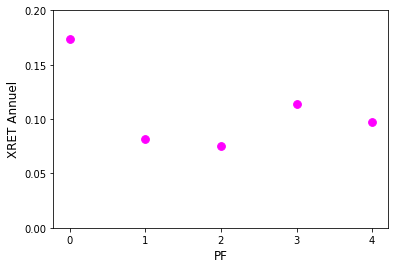

In [22]:
graph1 = plt.scatter(Group1["Final PF"],Group1["XRET Annuel"], s = 60, c = "magenta")
plt.xlabel("PF", size = 12)
plt.ylabel("XRET Annuel", size = 12)
plt.xticks(np.arange(0,5,step = 1))
plt.yticks(np.arange(0,0.21, step = 0.05))
print(graph1)

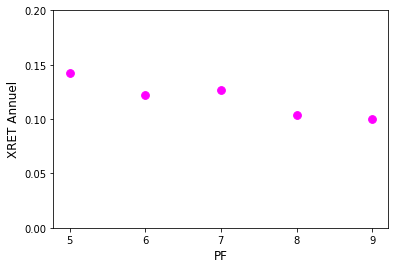

In [23]:
graph2 = plt.scatter(Group2["Final PF"],Group2["XRET Annuel"], s = 60, c = "magenta")
plt.xlabel("PF", size = 12)
plt.ylabel("XRET Annuel", size = 12)
plt.xticks(np.arange(5,10,step = 1))
plt.yticks(np.arange(0,0.21, step = 0.05))
print(graph2)

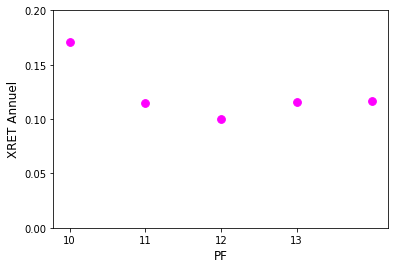

In [24]:
graph3 = plt.scatter(Group3["Final PF"],Group3["XRET Annuel"], s = 60, c = "magenta")
plt.xlabel("PF", size = 12)
plt.ylabel("XRET Annuel", size = 12)
plt.xticks(np.arange(10,14,step = 1))
plt.yticks(np.arange(0,0.21, step = 0.05))
print(graph3)

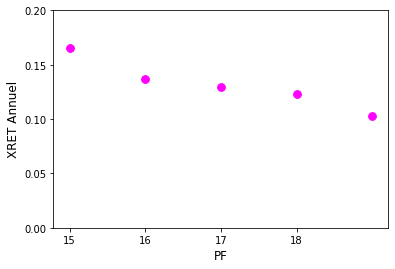

In [25]:
graph4 = plt.scatter(Group4["Final PF"],Group4["XRET Annuel"], s = 60, c = "magenta")
plt.xlabel("PF", size = 12)
plt.ylabel("XRET Annuel", size = 12)
plt.xticks(np.arange(15,19,step = 1))
plt.yticks(np.arange(0,0.21, step = 0.05))
print(graph4)

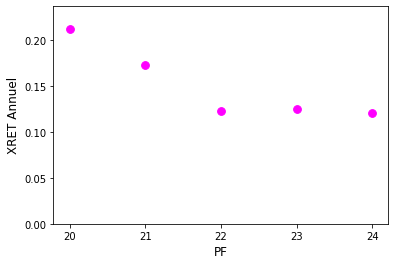

In [26]:
graph5 = plt.scatter(Group5["Final PF"],Group5["XRET Annuel"], s = 60, c = "magenta")
plt.xlabel("PF", size = 12)
plt.ylabel("XRET Annuel", size = 12)
plt.xticks(np.arange(20,25,step = 1))
plt.yticks(np.arange(0,0.21, step = 0.05))
print(graph5)

### Exemple de procédure de Test

    Période de Formation : 2015 - 2017
    Période de Réestimation : 2018 - 2020
    Période de Test : 2021

### Estimation des Betas et formation des 5 portefeuilles sur quintiles de Beta

In [27]:
fpb = (16,18)
epb = (19,21)
tstp = (22,22)
FormPeriodBetas = FormPeriod(fpb)
EstPeriodBetas = EstPeriod(epb,FormPeriodBetas)
display_side_by_side(FormPeriodBetas.head(),EstPeriodBetas.head())

Form PF 
 Beta Form 
 
 
 PERMNO 
 
 
 
 
 
 
 10026 
 1.0 
 0.636202 
 
 
 10032 
 1.0 
 0.548468 
 
 
 10044 
 1.0 
 0.596817 
 
 
 10065 
 2.0 
 1.083262 
 
 
 10138 
 3.0 
 1.219668 
 
 
 
 
 
 
 Beta Est 
 
 
 PERMNO 
 
 
 
 
 
 10026 
 0.590207 
 
 
 10032 
 1.146572 
 
 
 10044 
 1.188711 
 
 
 10065 
 1.006951 
 
 
 10138 
 1.097757

In [28]:
CombinedBetas = pd.merge(FormPeriodBetas, EstPeriodBetas, on = "PERMNO")
CombinedBetas.reset_index(inplace = True)
CombinedBetas.head()

,PERMNO,Form PF,Beta Form,Beta Est
0,10026,1.0,0.636202,0.590207
1,10032,1.0,0.548468,1.146572
2,10044,1.0,0.596817,1.188711
3,10065,2.0,1.083262,1.006951
4,10138,3.0,1.219668,1.097757


### Formation des 25 portefeuilles sur quintiles de capitalisation

In [29]:
FormPeriodMKCap,FinalPfs = FormFinalPF(epb, CombinedBetas)
display_side_by_side(FinalPfs.head(),FinalPfs.tail())

,PERMNO,Final PF
21619,10257,1
21626,10463,1
21627,10514,0
21628,10517,4
21629,10550,1
,PERMNO,Final PF
23511,92400,22
23515,92428,21
23525,92470,22
23526,92471,21


In [30]:
FormPeriodMKCap.head()

,PERMNO,date,PRC,RET,SHROUT,vwretd,Period,YearMonth,Month,MKT CAP,LOG MKT CAP,Mkt-RF,SMB,HML,RF,Form PF,Beta Form,Beta Est,Final PF
21619,10257,20201231,9.32,0.021930,12544.0,0.045049,21,202012,12,116910.08,11.669160,0.0463,0.0483,-0.0156,0.0001,0.0,0.324824,1.083907,1
21626,10463,20201231,2.81,-0.040956,31576.0,0.045049,21,202012,12,88728.56,11.393337,0.0463,0.0483,-0.0156,0.0001,0.0,0.279964,1.238424,1
21627,10514,20201231,14.63,0.145636,1905.0,0.045049,21,202012,12,27870.15,10.235312,0.0463,0.0483,-0.0156,0.0001,0.0,0.121621,0.778005,0
21628,10517,20201231,53.87,-0.002247,67557.0,0.045049,21,202012,12,3639295.59,15.107301,0.0463,0.0483,-0.0156,0.0001,0.0,-0.304205,2.052111,4
21629,10550,20201231,30.97,-0.176768,3861.0,0.045049,21,202012,12,119575.17,11.691700,0.0463,0.0483,-0.0156,0.0001,0.0,0.181133,1.291489,1


### Calcul des Betas et log capitalisations des portefeuilles 

In [31]:
By_PF = FormPeriodMKCap.groupby("Final PF")
PfBeta = pd.DataFrame(By_PF["Beta Est"].mean())
PfBeta.columns = ["PF Beta"]
PfCap = pd.DataFrame(By_PF["LOG MKT CAP"].mean())
PfCap.columns = ["PF Log Mkt Cap"]
PfData = pd.merge(PfBeta,PfCap, on = "Final PF")
display_side_by_side(PfData.head(),PfData.tail())

,PF Beta,PF Log Mkt Cap
Final PF,,
0.0,1.132046,10.506304
1.0,0.762292,11.800987
2.0,0.613015,12.846527
3.0,1.062490,14.256384
4.0,0.654721,16.404869
,PF Beta,PF Log Mkt Cap
Final PF,,
20.0,1.749511,11.252206
21.0,1.893803,13.025014


In [32]:
Mapping = pd.merge(CombinedBetas,FinalPfs, on = "PERMNO")
Mapping = pd.merge(Mapping,PfData, on = "Final PF")
Mapping.head()

,PERMNO,Form PF,Beta Form,Beta Est,Final PF,PF Beta,PF Log Mkt Cap
0,10026,1.0,0.636202,0.590207,8,1.124822,14.948316
1,10032,1.0,0.548468,1.146572,8,1.124822,14.948316
2,13936,1.0,0.687392,2.437606,8,1.124822,14.948316
3,17929,1.0,0.433124,0.981089,8,1.124822,14.948316
4,20750,1.0,0.405759,0.044119,8,1.124822,14.948316


In [33]:
TestPeriod = d3[d3["Period"].between(tstp[0],tstp[1], inclusive = True)] 
TestPeriod = pd.merge(TestPeriod,Mapping, on = "PERMNO")
TestPeriod.head()

,PERMNO,date,PRC,RET,SHROUT,vwretd,Period,YearMonth,Month,MKT CAP,...,Mkt-RF,SMB,HML,RF,Form PF,Beta Form,Beta Est,Final PF,PF Beta,PF Log Mkt Cap
0,10026,20210129,152.66000,-0.017442,18980.0,-0.000631,22,202101,1,2.897487e+06,...,-0.0003,0.0718,0.0294,0.0,1.0,0.636202,0.590207,8,1.124822,14.948316
1,10026,20210226,158.75999,0.039958,18980.0,0.029196,22,202102,2,3.013265e+06,...,0.0278,0.0197,0.0720,0.0,1.0,0.636202,0.590207,8,1.124822,14.948316
2,10026,20210331,157.03000,-0.007275,19034.0,0.030573,22,202103,3,2.988909e+06,...,0.0308,-0.0237,0.0732,0.0,1.0,0.636202,0.590207,8,1.124822,14.948316
3,10026,20210430,164.61000,0.048271,19036.0,0.048192,22,202104,4,3.133516e+06,...,0.0493,-0.0313,-0.0099,0.0,1.0,0.636202,0.590207,8,1.124822,14.948316
4,10026,20210528,175.58000,0.066642,19036.0,0.007092,22,202105,5,3.342341e+06,...,0.0029,-0.0024,0.0703,0.0,1.0,0.636202,0.590207,8,1.124822,14.948316


### Calcul des rendements en excès du taux sans risque mensuels des portefeuilles sur l'année de test

In [34]:
By_Mt_Pf = TestPeriod.groupby(["YearMonth","Final PF"])
PfRtMc = pd.DataFrame(By_Mt_Pf["PF Beta","RET","PF Log Mkt Cap","RF"].mean())
PfRtMc.reset_index(inplace = True)
PfRtMc.rename(columns = {"RET":"PF RET",}, inplace = True)
PfRtMc["XRET"] = PfRtMc["PF RET"] - PfRtMc["RF"] 
display_side_by_side(PfRtMc.head(),PfRtMc.tail())

,YearMonth,Final PF,PF Beta,PF RET,PF Log Mkt Cap,RF,XRET
0,202101,0.0,1.132046,0.176717,10.506304,0.0,0.176717
1,202101,1.0,0.762292,0.034327,11.800987,0.0,0.034327
2,202101,2.0,0.613015,0.031921,12.846527,0.0,0.031921
3,202101,3.0,1.062490,0.028849,14.256384,0.0,0.028849
4,202101,4.0,0.654721,-0.008364,16.404869,0.0,-0.008364
,YearMonth,Final PF,PF Beta,PF RET,PF Log Mkt Cap,RF,XRET
295,202112,20.0,1.749511,-0.036667,11.252206,0.0001,-0.036767
296,202112,21.0,1.893803,0.027262,13.025014,0.0001,0.027162
297,202112,22.0,1.579773,0.052231,14.071791,0.0001,0.052131
298,202112,23.0,1.726927,0.043307,15.143378,0.0001,0.043207


### Régression des rendements mensuels espérés des portefeuilles sur leurs Beta et log capitalisations

In [35]:
By_Month = PfRtMc.groupby("YearMonth")
GammasDeltas = pd.DataFrame(By_Month.apply(ComputeBetas,"XRET",["PF Beta","PF Log Mkt Cap"]))
GammasDeltas.columns = ["Gamma","Delta","Intercept"]
GD = pd.DataFrame()
GD = GD.append(GammasDeltas)
print(GD)

              Gamma     Delta  Intercept
YearMonth                               
202101     0.072529 -0.023017   0.293910
202102     0.095470 -0.005357   0.042477
202103    -0.008542  0.005652  -0.029012
202104    -0.023242  0.000917   0.049779
202105     0.018396 -0.004303   0.067698
202106     0.007863 -0.007408   0.105693
202107    -0.071331  0.004320   0.011747
202108     0.005675 -0.000223   0.017431
202109     0.013506 -0.005454   0.037968
202110     0.017865  0.008942  -0.113601
202111    -0.028454  0.003623  -0.047712
202112    -0.009513  0.010807  -0.104793


### Récupération des rendements mensuels moyens des 25 portefeuilles sur l'année de test

In [36]:
By_PF2 = PfRtMc.groupby(["Final PF"])
Pf_Mean_Rt = pd.DataFrame(By_PF2["XRET"].mean())
MMXRET = pd.DataFrame()
MMXRET = MMXRET.append(Pf_Mean_Rt)
print(MMXRET)

              XRET
Final PF          
0.0       0.047892
1.0       0.014221
2.0       0.004991
3.0       0.015482
4.0       0.017246
5.0       0.034433
6.0       0.024139
7.0       0.028467
8.0       0.020125
9.0       0.019067
10.0      0.025777
11.0      0.025674
12.0      0.023005
13.0      0.022356
14.0      0.021096
15.0      0.016172
16.0      0.026791
17.0      0.022034
18.0      0.024076
19.0      0.021952
20.0      0.020022
21.0      0.030386
22.0      0.026453
23.0      0.024124
24.0      0.023238
